# Precipitation development for MPI model data

This notebook aims to analyse the precipitation data as a sum of large scale precipitation (var142) and convective precipitation (var143) of the Earth System Model of the MPI for Meteorology (MPI-ESMI1.2). The data is given in a netcdf file with monthly values for latitudes and longitudes in a resolution of 1.875° x 1.875°.

The annual mean precipitation and the seasonal mean precipitation are calculated and plotted for the whole earth and for the Baltic Sea region.

## First steps:

At first some python libraries are imported:

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, Point

The model data is imported as a dataset and large scale and convective precipitation are added together:

In [2]:
large_scale_prec = xr.open_dataset("/students_files/data/slo0043_echam6_code142_mm_1001_8850.ncslo0043_echam6_code142_mm_1001_8850.nc")
convective_prec = xr.open_dataset("/students_files/data/slo0043_echam6_code143_mm_1001_8850.ncslo0043_echam6_code143_mm_1001_8850.nc")
sum_var = large_scale_prec['var142'] + convective_prec['var143']
prec = xr.Dataset({'var260': sum_var})
prec = prec.assign_coords(coords=large_scale_prec.coords)

The longitude and latitude coordinates are adjusted and the dataset is shown:

In [3]:
# adjust values of lon and lat and show dataset

def adjust_lon_lat(ds, lon_name, lat_name, reverse = False):
    """Adjusts longitude from 0 to 360 to -180 to 180 and reverses latitude."""
    if reverse == True:
        ds = ds.reindex({lat_name:ds[lat_name][::-1]})
    ds['_longitude_adjusted'] = xr.where(
        ds[lon_name] > 180,
        ds[lon_name] - 360,
        ds[lon_name])
    ds = (ds
          .swap_dims({lon_name: '_longitude_adjusted'})
          .sel(**{'_longitude_adjusted': sorted(ds._longitude_adjusted)})
          .drop(lon_name))
    ds = ds.rename({'_longitude_adjusted': lon_name})
    return ds
prec = adjust_lon_lat(prec, lon_name="lon", lat_name="lat", reverse=True)

print(prec)

<xarray.Dataset>
Dimensions:  (lat: 96, lon: 192, time: 94200)
Coordinates:
  * lat      (lat) float64 -88.57 -86.72 -84.86 -83.0 ... 83.0 84.86 86.72 88.57
  * time     (time) float64 1.001e+07 1.001e+07 1.001e+07 ... 8.85e+07 8.85e+07
  * lon      (lon) float64 -178.1 -176.2 -174.4 -172.5 ... 176.2 178.1 180.0
Data variables:
    var260   (time, lat, lon) float32 7.13655e-07 7.221388e-07 ... 5.5752316e-06


## Baltic region mean precipitation:

Creating a Baltic Sea drainage basin boolean mask:

In [4]:
corner_points = [
    (18.0, 49),
    (23.0, 49),
    (28.0, 55.0),
    (32.0, 56.0),
    (35.0, 62.0),
    (30.0, 62.0),
    (29.0, 67.0),
    (19.0, 68.0),
    (12.0, 61.0),
    (12.0, 57.5),
    (8.0, 56.5),
    (10.0, 53.0),
    (13.5, 52.5)
]

polygon = Polygon(corner_points)

lat_mask = (prec['lat'] >= polygon.bounds[1]) & (prec['lat'] <= polygon.bounds[3])
lon_mask = (prec['lon'] >= polygon.bounds[0]) & (prec['lon'] <= polygon.bounds[2])
mask = (lat_mask & lon_mask)

lat_values = prec['lat'].values
lon_values = prec['lon'].values
for i in range(len(lat_values)):
    for j in range(len(lon_values)):
        if not polygon.contains(Point(lon_values[j], lat_values[i])):
            mask[i, j] = False

The baltic region outline is prepared:

In [5]:
import matplotlib.ticker as mticker
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

def subplot_cartopy_nice_baltic(ax):    
    """
    Adjust cartopy plots for the Baltic Sea
    """
    ax.set_aspect("auto")
    ax.coastlines("10m")
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                    linewidth=2, color='gray', alpha=0.0, linestyle='-')
    gl.top_labels  = False
    gl.left_labels  = True
    gl.right_labels  = False
    gl.xlines = True
    gl.ylines = True
    gl.xlocator = mticker.FixedLocator(list(np.arange(-90, 60, 10)))
    gl.ylocator = mticker.FixedLocator(list(np.arange(-60, 80, 5)))

    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER

    ax.spines['geo'].set_linewidth(5)
    ax.spines['geo'].set_edgecolor('black')
    ax.set_aspect('auto')

Plot of the mask:

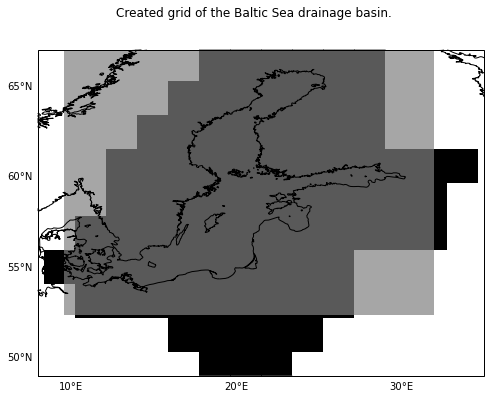

In [6]:
import matplotlib.pyplot as plt
import numpy as np

prec['lon'] = np.reshape(prec['lon'], (-1,))
prec['lat'] = np.reshape(prec['lat'], (-1,))

x, y = np.meshgrid(prec['lon'], prec['lat'])

fig, ax = plt.subplots(figsize=(8, 6), subplot_kw=dict(projection=ccrs.PlateCarree())) # define projections
im = plt.pcolormesh(x, y, mask, cmap='gray_r', shading='auto', transform=ccrs.PlateCarree()) # The data needs to be transformed for the projection
im = plt.axvspan(9.6, 32, ymin=0.185, ymax=1, facecolor='grey', alpha=0.7)

subplot_cartopy_nice_baltic(ax)
ax.spines['geo'].set_linewidth(1)

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.xlim(8, 35)
plt.ylim(49, 67,4)
plt.suptitle('Created grid of the Baltic Sea drainage basin.');
# plt.figtext(0, -0.1, 'The mask uses 12 corner points (see code above for coordinates). The deviation from \n common drainage basin maps is a result of different coordinate systems being used.');


The precipitation values are averaged for the baltic region:

In [12]:
prec_baltic = prec.where(mask)
prec_baltic = prec_baltic * 86400
mean_prec_baltic = prec_baltic.mean(dim=['lat', 'lon'])

The following cell calculates and plots the baltic region annual mean precipitation:

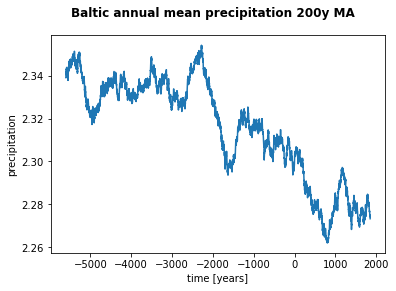

In [13]:
rolling_mean = mean_prec_baltic.rolling(time=12).mean().isel(time=slice(11, None, 12))
rolling_mean = rolling_mean.rolling(time=400).mean()
rolling_mean['time'] = xr.DataArray(range(-6000, rolling_mean.time.size-6000), dims='time')

plt.plot(rolling_mean['time'], rolling_mean['var260'])
plt.xlabel('time [years]')
plt.ylabel('precipitation')
plt.suptitle('Baltic annual mean precipitation 200y MA', fontweight='bold')
plt.show()

The following cell calculates and plots the baltic region seasonal mean precipitation:

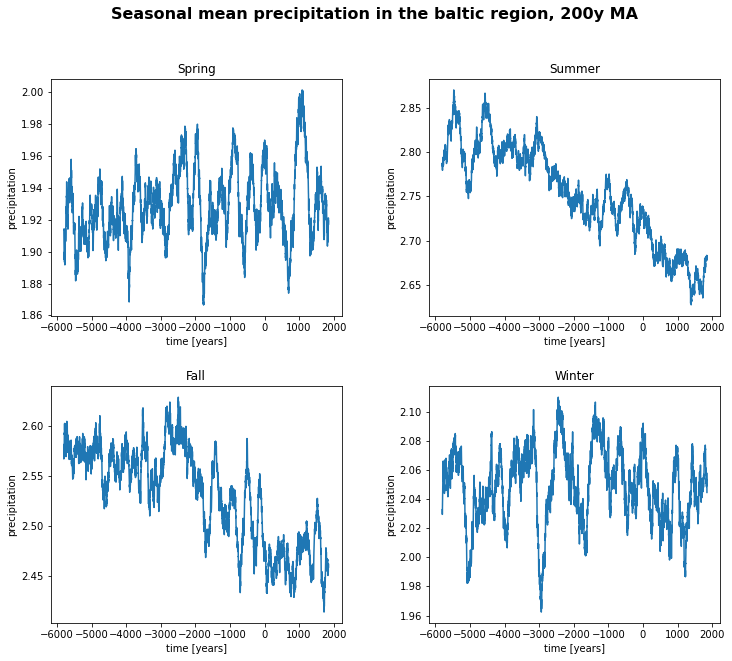

In [14]:
rolling_data = mean_prec_baltic.isel(time=slice(2, None))
rolling_data = rolling_data['var260'].rolling(time=3, center=False, min_periods=3).mean()
rolling_data = rolling_data[2::3]
seasonal_mean_prec_baltic = xr.Dataset({"var260": ("time", rolling_data)}, coords={"time": rolling_data.coords["time"]})

# Creating spring_mean_prec_baltic DataArray and applying 200y MA
spring_mean_prec_baltic = seasonal_mean_prec_baltic['var260'][0::4]
spring_mean_prec_baltic.coords['time'] = range(-6000, -6000+len(spring_mean_prec_baltic))
spring_mean_prec_baltic = spring_mean_prec_baltic.rolling(time=200).mean()

# Creating summer_mean_prec_baltic DataArray and applying 200y MA
summer_mean_prec_baltic = seasonal_mean_prec_baltic['var260'][1::4]
summer_mean_prec_baltic.coords['time'] = range(-6000, -6000+len(summer_mean_prec_baltic))
summer_mean_prec_baltic = summer_mean_prec_baltic.rolling(time=200).mean()

# Creating fall_mean_prec_baltic DataArray and applying 200y MA
fall_mean_prec_baltic = seasonal_mean_prec_baltic['var260'][2::4]
fall_mean_prec_baltic.coords['time'] = range(-6000, -6000+len(fall_mean_prec_baltic))
fall_mean_prec_baltic = fall_mean_prec_baltic.rolling(time=200).mean()

# Creating winter_mean_prec_baltic DataArray and applying 200y MA
winter_mean_prec_baltic = seasonal_mean_prec_baltic['var260'][3::4]
winter_mean_prec_baltic.coords['time'] = range(-6000, -6000+len(winter_mean_prec_baltic))
winter_mean_prec_baltic = winter_mean_prec_baltic.rolling(time=200).mean()


# Creating the four plots
fig, axs = plt.subplots(2, 2, figsize=(12,10), gridspec_kw={"hspace": 0.3, "wspace": 0.3})

im1 = axs[0,0].plot(spring_mean_prec_baltic['time'], spring_mean_prec_baltic)
axs[0,0].set_title('Spring')
axs[0,0].set_xlabel('time [years]')
axs[0,0].set_ylabel('precipitation')

im2 = axs[0,1].plot(summer_mean_prec_baltic['time'], summer_mean_prec_baltic)
axs[0,1].set_title('Summer')
axs[0,1].set_xlabel('time [years]')
axs[0,1].set_ylabel('precipitation')

im3 = axs[1,0].plot(fall_mean_prec_baltic['time'], fall_mean_prec_baltic)
axs[1,0].set_title('Fall')
axs[1,0].set_xlabel('time [years]')
axs[1,0].set_ylabel('precipitation')

im4 = axs[1,1].plot(winter_mean_prec_baltic['time'], winter_mean_prec_baltic)
axs[1,1].set_title('Winter')
axs[1,1].set_xlabel('time [years]')
axs[1,1].set_ylabel('precipitation');

fig.suptitle('Seasonal mean precipitation in the baltic region, 200y MA', fontsize=16, fontweight='bold');

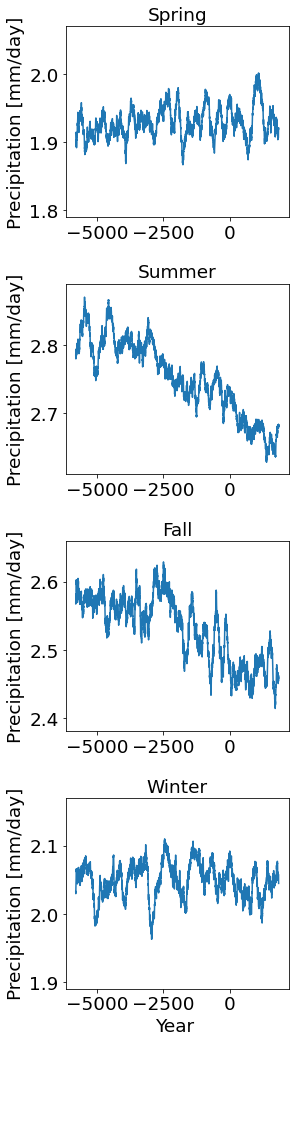

In [23]:
# Creating the four plots
fig, axs = plt.subplots(4, 1, figsize=(4,17.7), gridspec_kw={"hspace": 0.35, "wspace": 0.3})

im1 = axs[0].plot(spring_mean_prec_baltic['time'], spring_mean_prec_baltic)
axs[0].set_title('Spring', fontsize = '18.5')
#axs[0].set_xlabel('Year')
axs[0].set_ylabel('Precipitation [mm/day]', fontsize=18.5)
axs[0].tick_params(axis='both', labelsize=18.5)
axs[0].set_ylim([1.79, 2.07])

im2 = axs[1].plot(summer_mean_prec_baltic['time'], summer_mean_prec_baltic)
axs[1].set_title('Summer', fontsize = '18.5')
#axs[1].set_xlabel('Year')
axs[1].set_ylabel('Precipitation [mm/day]', fontsize=18.5)
axs[1].tick_params(axis='both', which='major', labelsize=18.5)
axs[1].set_ylim([2.61, 2.89])

im3 = axs[2].plot(fall_mean_prec_baltic['time'], fall_mean_prec_baltic)
axs[2].set_title('Fall', fontsize = '18.5')
#axs[2].set_xlabel('Year', fontsize=18)
axs[2].set_ylabel('Precipitation [mm/day]', fontsize=18.5)
axs[2].tick_params(axis='both', which='major', labelsize=18.5)
axs[2].set_ylim([2.38, 2.66])

im4 = axs[3].plot(winter_mean_prec_baltic['time'], winter_mean_prec_baltic)
axs[3].set_title('Winter', fontsize = '18.5')
axs[3].set_xlabel('Year \n\n\n\n', fontsize=18.5)
axs[3].set_ylabel('Precipitation [mm/day]', fontsize=18.5)
axs[3].tick_params(axis='both', which='major', labelsize=18.5)
axs[3].set_ylim([1.89, 2.17])

plt.savefig("/students_files/marti/plots/res_05_seas_prec_line", bbox_inches='tight');